In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import multiprocessing
import ctypes
import numpy as np
import sys
import shutil
import cv2
from glob import glob
import matplotlib.pyplot as plt
from evaluation.test_datasets import FaceRecogntioniDataset
from evaluation.ijb_evals import plot_dir_far_scores
from face_lib.datasets.qmul import SurvFace

In [1]:
import pandas as pd

df = pd.read_csv(
    "/app/experiments/pooling_methods/IJBC/open_set_identification/open_set_recognition.csv"
)

In [8]:
numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

newdf = df.select_dtypes(include=numerics)

In [11]:
for column in newdf.columns:
    pass

In [12]:
column

'final_top_20_recall_at_far_1'

In [3]:
for row_index, (model, row) in enumerate(df.iterrows()):
    print(row)

0
1
2
3
4
5


In [6]:
row["pretty_name"]

'CosineSim_DetScore_PFEHarmonicMean-Pool'

In [4]:
row_index

5

In [2]:
df

,model_name,final_AUC_1_rank,final_top_1_recall_at_far_0.0001,final_top_1_recall_at_far_0.001,final_top_1_recall_at_far_0.01,final_top_1_recall_at_far_0.1,final_top_1_recall_at_far_1,final_AUC_5_rank,final_top_5_recall_at_far_0.0001,final_top_5_recall_at_far_0.001,...,final_top_10_recall_at_far_0.001,final_top_10_recall_at_far_0.01,final_top_10_recall_at_far_0.1,final_top_10_recall_at_far_1,final_AUC_20_rank,final_top_20_recall_at_far_0.0001,final_top_20_recall_at_far_0.001,final_top_20_recall_at_far_0.01,final_top_20_recall_at_far_0.1,final_top_20_recall_at_far_1
0,pooling-with-PoolingSCF_use-det-score-True_eva...,0.968227,0.460910,0.829266,0.944261,0.963392,0.972182,0.973912,0.460910,0.829266,...,0.829266,0.944674,0.966184,0.983247,0.976651,0.460910,0.829266,0.944674,0.966494,0.985315
1,pooling-with-PoolingSCF_use-det-score-True_eva...,0.968645,0.407653,0.837642,0.945812,0.964943,0.972182,0.974308,0.407653,0.837642,...,0.837642,0.946122,0.967218,0.983247,0.976861,0.407653,0.837642,0.946122,0.967322,0.985315


In [ ]:
import pandas as pd
import numpy as np

fars = [np.arange(20) for _ in range(10)]
recalls = [np.arange(20) + 30 for _ in range(10)]
method_names = [f"m_{i}" for i in range(10)]

rows = []

for i in range(10):
    rows.append([method_names[i]] + list(fars[i]) + list(recalls[i]))

In [2]:
import numpy as np

np.arange(0, 1 + 0.1, step=0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [14]:
a["template_pooled_unc"].shape

(23124, 512)

In [12]:
list(a.keys())

['template_pooled_emb', 'template_pooled_unc', 'template_ids']

### Create SurvFace metadata

In [24]:
# create survface_face_tid_mid.txt
# we suppose that media is different for each samples
dataset = SurvFace("/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set")

with open(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/meta/survface_face_tid_mid.txt",
    "w",
) as fd:
    i = 0
    medias = np.arange(len(dataset))
    for template_id in dataset.gallery_template_ids:
        fd.write(f"{dataset.image_short_names[i]} {template_id} {medias[i]}\n")
        i += 1
    for template_id in dataset.mated_probe_template_ids:
        fd.write(f"{dataset.image_short_names[i]} {template_id} {medias[i]}\n")
        i += 1
    for template_id in dataset.unmated_probe_template_ids:
        fd.write(f"{dataset.image_short_names[i]} {template_id} {medias[i]}\n")
        i += 1

In [28]:
# create survface_1N_gallery_G1.csv
import pandas as pd

gallery_id_data = {
    "TEMPLATE_ID": dataset.gallery_template_ids,
    "SUBJECT_ID": dataset.gallery_ids,
    "FILENAME": dataset.image_short_names[: len(dataset.gallery_ids)],
}
df = pd.DataFrame(data=gallery_id_data)
df.to_csv(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/meta/survface_1N_gallery_G1.csv",
    index=False,
)

In [31]:
# create survface_1N_probe_mixed.csv
import pandas as pd

template_id = (
    dataset.mated_probe_template_ids.tolist()
    + dataset.unmated_probe_template_ids.tolist()
)
subject_id = dataset.mated_probe_ids.tolist() + dataset.unmated_probe_ids.tolist()
probe_id_data = {
    "TEMPLATE_ID": template_id,
    "SUBJECT_ID": subject_id,
    "FILENAME": dataset.image_short_names[len(dataset.gallery_ids) :],
}
df = pd.DataFrame(data=probe_id_data)
df.to_csv(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/meta/survface_1N_probe_mixed.csv",
    index=False,
)

In [19]:
set(dataset.gallery_template_ids).intersection(set(dataset.mated_probe_template_ids))

set()

In [21]:
set(dataset.gallery_template_ids).intersection(set(dataset.unmated_probe_template_ids))

set()

In [22]:
set(dataset.mated_probe_template_ids).intersection(
    set(dataset.unmated_probe_template_ids)
)

set()

In [23]:
set(dataset.unmated_probe_ids).intersection(set(dataset.gallery_ids))

set()

In [8]:
assert (set(dataset.gallery_ids)) == set(dataset.mated_probe_ids)

In [14]:
dataset.gallery_template_ids[:200]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  4,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=uint16)

In [13]:
dataset.mated_probe_ids[:200]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  4,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11], dtype=uint16)

In [15]:
dataset.mated_probe_template_ids[:200]

array([5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320,
       5320, 5320, 5320, 5320, 5320, 5320, 5320, 5320, 5323, 5325, 5328,
       5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328,
       5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328,
       5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328, 5328,
       5328, 5328, 5328, 5328, 5328, 5328, 5328, 53

In [17]:
dataset.unmated_probe_ids

array([5319, 5320, 5321, ..., 8316, 8317, 8318])

In [18]:
dataset.unmated_probe_template_ids

array([15957, 15958, 15959, ..., 18954, 18955, 18956])

In [3]:
a = np.load("/app/cache/features/pfe_qmul_survFace.npz")

In [9]:
np.exp(a["unc"]) ** 0.5

array([[0.05713168, 0.05248559, 0.04987973, ..., 0.05157684, 0.05030818,
        0.0543626 ],
       [0.04836658, 0.04669207, 0.0470348 , ..., 0.04875289, 0.04657172,
        0.04417749],
       [0.04804879, 0.04335583, 0.0441819 , ..., 0.04498498, 0.04813632,
        0.04209794],
       ...,
       [0.05014598, 0.05014416, 0.04968883, ..., 0.04902398, 0.04871278,
        0.04757581],
       [0.04999655, 0.04704627, 0.04745691, ..., 0.04860072, 0.04618262,
        0.04694822],
       [0.05930768, 0.05543486, 0.05102114, ..., 0.05300561, 0.05416605,
        0.05105976]], dtype=float32)

In [4]:
b = np.load("/app/datasets/arcface_ijb/IJBC/embeddings/scf_ijb_embs_IJBC.npz")
b["unc"].shape

(469375, 1)

In [3]:
a["unc"].shape

(123717, 1)

In [2]:
dataset = SurvFace("/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set")

In [3]:
len(dataset)

123717

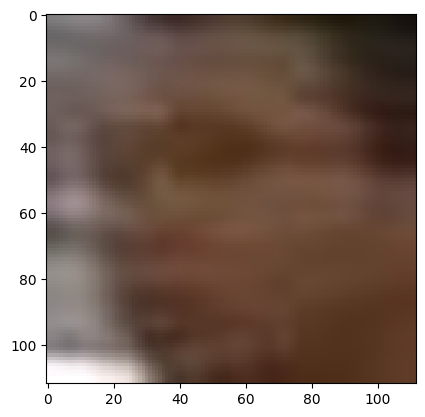

In [19]:
plt.imshow((dataset[8] / 0.0078125 + 127.5).astype("uint8"))

In [93]:
unmated_probe = list(
    glob("/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/unmated_probe/*")
)
unmated_probe = [probe_path.split("/")[-1] for probe_path in unmated_probe]
len(unmated_probe)

121736

In [95]:
from numpy.random import RandomState

rs = RandomState(1572)
probe_subset = rs.choice(unmated_probe, 3000, replace=False)

In [97]:
np.save(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/unmated_probe_subset.npy",
    probe_subset,
)

In [78]:
names = []
with open(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/gallery_names.txt"
) as fd:
    for line in fd.read().splitlines():
        names.append(line)
len(names)

60294

In [81]:
gallery_ids = [int(name.split("_")[0]) for name in names]
len(set(gallery_ids))

In [80]:
probe = []
with open(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/probe_names.txt"
) as fd:
    for line in fd.read().splitlines():
        probe.append(line)
len(probe)

60423

In [84]:
probe_ids = [int(name.split("_")[0]) for name in probe]
len(set(probe_ids))

3000

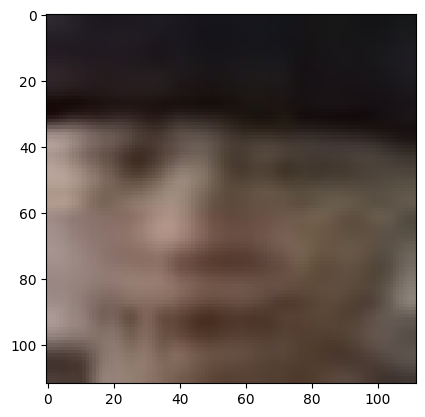

In [65]:
image = cv2.imread("/app/outputs/qmul_test/probe/11/10029_cam2_59.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (112, 112), interpolation=cv2.INTER_CUBIC)
plt.imshow(image)

In [22]:
import scipy.io

mat = scipy.io.loadmat(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/gallery_img_ID_pairs.mat"
)
mat_probe = scipy.io.loadmat(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/mated_probe_img_ID_pairs.mat"
)

In [67]:
mated_probe_ids = np.squeeze(mat_probe["mated_probe_ids"])
mated_probe_set = np.array(
    [image_name[0] for image_name in np.squeeze(mat_probe["mated_probe_set"])]
)
len(mated_probe_set), len(np.unique(mated_probe_ids))

(60423, 3000)

In [99]:
mated_probe_set

array(['10002_cam3_1.jpg', '10002_cam3_10.jpg', '10002_cam3_100.jpg', ...,
       '9998_cam2_7.jpg', '9998_cam2_8.jpg', '9998_cam2_9.jpg'],
      dtype='<U18')

In [58]:
from pathlib import Path

probe_path = Path(
    "/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/mated_probe"
)
id = 11
out_path = Path(f"/app/outputs/qmul_test/probe/{id}")
out_path.mkdir()
for image_path in mated_probe_set[np.where(mated_probe_ids == id)]:
    shutil.copyfile(probe_path / image_path, out_path / image_path)

In [23]:
gallery_ids = np.squeeze(mat["gallery_ids"])
gallery_set = np.array([image_name[0] for image_name in np.squeeze(mat["gallery_set"])])
len(gallery_ids), len(np.unique(gallery_ids))

(60294, 3000)

In [24]:
gallery_set[8]

'10002_cam2_104.jpg'

In [100]:
gallery_set

array(['10002_cam1_1.jpg', '10002_cam1_2.jpg', '10002_cam2_1.jpg', ...,
       '9998_cam3_7.jpg', '9998_cam3_8.jpg', '9998_cam3_9.jpg'],
      dtype='<U18')

In [56]:
gallery_ids[:400]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  4,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10

In [57]:
from pathlib import Path

gallery_path = Path("/app/datasets/QMUL-SurvFace/Face_Identification_Test_Set/gallery")
id = 11
out_path = Path(f"/app/outputs/qmul_test/{id}")
out_path.mkdir()
for image_path in gallery_set[np.where(gallery_ids == id)]:
    shutil.copyfile(gallery_path / image_path, out_path / image_path)

In [18]:
mat["gallery_set"]

array([[array(['10002_cam1_1.jpg'], dtype='<U16')],
       [array(['10002_cam1_2.jpg'], dtype='<U16')],
       [array(['10002_cam2_1.jpg'], dtype='<U16')],
       ...,
       [array(['9998_cam3_7.jpg'], dtype='<U15')],
       [array(['9998_cam3_8.jpg'], dtype='<U15')],
       [array(['9998_cam3_9.jpg'], dtype='<U15')]], dtype=object)

In [17]:
gallery_set

array([array(['10002_cam1_1.jpg'], dtype='<U16'),
       array(['10002_cam1_2.jpg'], dtype='<U16'),
       array(['10002_cam2_1.jpg'], dtype='<U16'), ...,
       array(['9998_cam3_7.jpg'], dtype='<U15'),
       array(['9998_cam3_8.jpg'], dtype='<U15'),
       array(['9998_cam3_9.jpg'], dtype='<U15')], dtype=object)